In [ ]:
import numpy as np
import cv2
import math
import os.path, sys
from PIL import Image, ImageOps
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def crop_bbox(border):
  box_array_2_all = []
  i = 0
  for item in dirs:
    fullpath = os.path.join(path,item)
    if os.path.isfile(fullpath):
      image = cv2.imread(fullpath)
      cv2.imwrite("Test1.png", image)
      ImageOps.expand(Image.open('Test1.png'), border=border, fill='white').save('Test.png')
      img = cv2.imread("Test.png")
      image_shape = img.shape
      
      img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
      ret, thresh = cv2.threshold(blurred,0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
      contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      box_array_2 = []
      i += 1
      z = 0
      for c1 in contours:
        areaC = cv2.contourArea(c1) 
        if areaC < 500 or areaC >= 300000:
          continue  
        print(areaC)      
        z += 1
        rect = cv2.minAreaRect(c1)
        (x, y), (width, height), angle = rect
        x=round(x)
        y=round(y)
        width=round(width)
        height=round(height)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        src_pts = box.astype("float32")
        dst_pts2 = np.array([[0, height-1],[0, 0], [width-1, 0], [width-1, height-1]], dtype="float32")
        M2 = cv2.getPerspectiveTransform(src_pts, dst_pts2)
        warped = cv2.warpPerspective(img, M2, (width, height))
        dddd = os.path.join(dest,"noise{}_{}.jpg".format(i, z))
        cv2.imwrite(dddd, warped)

        x_1, y_1, w_1, h_1 = cv2.boundingRect(c1)
        box_array = [[x_1, y_1], [x_1, y_1+h_1], [x_1+w_1, y_1+h_1], [x_1+w_1, y_1]]
        #img_box = cv2.rectangle(img, (x_1, y_1), (x_1+w_1, y_1+h_1), color = (255, 0, 0), thickness = 0)
        box_array_2.append(box_array)   
      box_array_2_all.append(box_array_2)  
  return (image_shape, box_array_2_all)



In [ ]:
import os
from lxml import etree as et

In [ ]:
def find_xy_from_box1(box_array_all2, label):
  box_array_xy_final = []
  for i in range(len(box_array_all2)):
    box_array_all2_xy = []
    for r in range(len(box_array_all2[i])):
      xmin = min(box_array_all2[i][r][0][0], box_array_all2[i][r][1][0], box_array_all2[i][r][2][0], box_array_all2[i][r][3][0]) - border
      ymin = min(box_array_all2[i][r][0][1], box_array_all2[i][r][1][1], box_array_all2[i][r][2][1], box_array_all2[i][r][3][1]) - border
      xmax = max(box_array_all2[i][r][0][0], box_array_all2[i][r][1][0], box_array_all2[i][r][2][0], box_array_all2[i][r][3][0]) - border
      ymax = max(box_array_all2[i][r][0][1], box_array_all2[i][r][1][1], box_array_all2[i][r][2][1], box_array_all2[i][r][3][1]) - border
      box_array_all2_xy.append((label, 'Unspecified', '0', '0', [xmin, ymin, xmax, ymax]))
    box_array_xy_final.append(box_array_all2_xy)
  return box_array_xy_final

In [ ]:
def create_xml(dir, imgfilepath, object_list, size_tuple, savedir):
    """
    params:
    - imgfilepath: path of corresponding img file. only the basename will be actually used.
    - object_list: python list of element in tuple of (classname, [x1,y1,x2,y2])
    - savedir: output directory to save generated xml file
    """
    basename = os.path.basename(imgfilepath)
    filename, _ = os.path.splitext(basename)
    root = et.Element('annotation')
    
    fn_elem = et.SubElement(root, 'filename')
    bn = os.path.basename(imgfilepath)
    fn, _ = os.path.splitext(bn)
    img_bn = f"{fn}.jpg"
    fn_elem.text = img_bn

    path = et.SubElement(root, 'path')
    path.text = dir + imgfilepath

    source = et.SubElement(root, 'source')
    database = et.SubElement(source, 'database')
    database.text = 'Unknown'

    size = et.SubElement(root, 'size')
    width = et.SubElement(size, 'width')
    width.text = str(size_tuple[0])
    height = et.SubElement(size, 'height')
    height.text = str(size_tuple[1])
    depth = et.SubElement(size, 'depth')
    depth.text = str(size_tuple[2])

    segmented = et.SubElement(root, 'segmented')
    segmented.text = '0'
    
    for classname, unspecified, zero, zero, (x1,y1,x2,y2) in object_list:
        object_elem = et.SubElement(root, 'object')
        
        name = et.SubElement(object_elem, 'name')
        name.text = classname

        pose = et.SubElement(object_elem, 'pose')
        pose.text = unspecified

        trauncated = et.SubElement(object_elem, 'trauncated')
        trauncated.text = zero

        difficult = et.SubElement(object_elem, 'difficult')
        difficult.text = zero

        bndbox = et.SubElement(object_elem, 'bndbox')
        xmin = et.SubElement(bndbox, 'xmin')
        xmin.text = str(x1)
        ymin = et.SubElement(bndbox, 'ymin')
        ymin.text = str(y1)
        xmax = et.SubElement(bndbox, 'xmax')
        xmax.text = str(x2)
        ymax = et.SubElement(bndbox, 'ymax')
        ymax.text = str(y2)
    out = et.tostring(root, pretty_print=True, encoding='utf8') # if element attributes contains some non ascii characters, then need to specify encoding. if not the case, then encoding doesn't need to be set
    savepath = os.path.join(savedir, f'{fn}.xml')
    with open(savepath, 'wb') as fd:
        fd.write(out)
    print(savepath)

def create_xml_from_dir(dir, backscaled_xy_list, savedir):
  dirs = os.listdir(dir) #select jpg files only from directory
  jpg_dirs = []
  for i in range(len(dirs)):
    if '.jpg' in dirs[i]:
      jpg_dirs.append(dirs[i])

  for i in range(len(jpg_dirs)): #generates jpg file to XML
    if len(jpg_dirs) == len(backscaled_xy_list):
      imgfilepath = jpg_dirs[i]
      object_list = backscaled_xy_list[i]
      create_xml(dir, imgfilepath, object_list, size_tuple, savedir)
    else:
      print('len(jpg_dirs)', len(jpg_dirs), 'len(backscaled_xy_list)', len(backscaled_xy_list))
      print('dir contains other files than jpg')

In [ ]:
###only change this path
label = 'w'

path = r"/content/drive/My Drive/Colab Notebooks/GoMicro/Wheat/wheat_weeviled"

folder = "normal"
dirs = os.listdir(path)

dest = os.path.join(r"/content/drive/My Drive/Colab Notebooks/GoMicro/Wheat/wheat_weeviled", folder)
if not os.path.exists(dest):
    os.makedirs(dest)

In [ ]:
border=20
image_shape, box_array_2_all = crop_bbox(border)

4398.0
5400.0
5492.5
4941.0
5415.0
7950.0
4100.0
4849.0
5509.0
4916.0
4002.5
3905.0
5242.5
5302.5
4949.0
5359.5
3977.0
5945.5
4363.0
4349.0
4336.5
5474.0
3656.5
5533.5
10062.5
5353.0
4419.5
5753.0
4454.5
5218.5
4070.5
4042.5
5684.0
4550.0
4414.0
4155.0
5046.5
6049.5
3775.5
4503.5
4242.5
4786.0
4966.0
4470.5
5404.5
5306.0
5066.0
4286.0
5445.5
3551.5
4787.0
5355.5
4426.5
4882.5
4714.5
4848.5
3740.5
5244.0
4864.0
3963.5
3363.0
6354.0
4907.0
4957.5
4563.0
5239.5
4462.0
4149.5
5404.0
4634.5
5172.0
5521.5
5651.0
4589.5
3001.5
4820.0
5058.0
4804.0
3621.0
3968.0
4374.5
5525.5
4696.0
4450.5
5816.0
5526.5
5311.5
3540.0
4319.0
4121.0
4870.5
5511.5
5163.0
4259.5
5027.5
4238.5
4631.0
5027.0
4693.0
3430.0
4329.5
4456.0
4101.0
4444.5
4762.5
5699.5
4304.0
5251.0
4675.5
3474.5
4192.5
4474.5
8796.0
4170.5
280267.5
24552.0
1319.0
3401.0
1603.5
1225.5
1805.5
4034.5
1583.0
2187.5
22629.0
27143.5
7768.0
2864.0
5148.5
6506.0
1358.0
1030.0
13154.5
27396.0
16368.5
14415.5
20523.0
22412.5
20870.5
18718.0
25340.

In [ ]:
box_array_xy_final = find_xy_from_box1(box_array_2_all, label)

dir = path
savedir = path
size_tuple = image_shape

create_xml_from_dir(dir, box_array_xy_final, savedir)



```
# This is formatted as code
```

**Save transparent background png of cropped images**

In [ ]:
import cv2
  
path = r'/content/drive/My Drive/Colab Notebooks/GoMicro/Wheat/Testing'
dirs = os.listdir(path)

for item in dirs:
    fullpath = os.path.join(path,item)
    if os.path.isfile(fullpath):
      image = cv2.imread(fullpath)
      plt.imshow(image)

In [ ]:
import numpy as np
import cv2
import math
import os.path, sys
from PIL import Image, ImageOps
from matplotlib import pyplot as plt

**Export contour as PNG file**

True

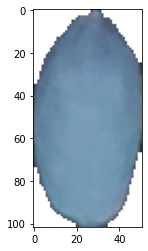

In [ ]:
#https://stackoverflow.com/questions/63221977/drawing-opencv-contours-and-save-as-transparent-image
#https://stackoverflow.com/questions/63001988/how-to-remove-background-of-images-in-python
#path = r"/content/drive/My Drive/Colab Notebooks/GoMicro/Wheat/wheat_stalk"

path_img = '/content/drive/My Drive/Colab Notebooks/GoMicro/Wheat/wheat_normal/normal/noise1_15.jpg'
dest = '/content/drive/My Drive/Colab Notebooks/GoMicro/Wheat/wheat_normal/normal/'

img = cv2.imread(path_img)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# we get ret from THRESH_OTSU then minus 12 and do global threshold to get a outer border
ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret = ret - 12
ret, thresh = cv2.threshold(img_gray, ret, 255 ,cv2.THRESH_BINARY)

mask = thresh

kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask -- blur then stretch / blur alpha channel
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=0.1, sigmaY=0.1, borderType = cv2.BORDER_DEFAULT)

# linear stretch so that 127.5 goes to 0, but 255 stays 255
mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

# put mask into alpha channel
result = img.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

plt.imshow(result)

# save resulting masked image
dddd = os.path.join(dest,"0_bg{}_{}.png".format(1, 1))
cv2.imwrite(dddd, result)



### Rotate 90 degrees


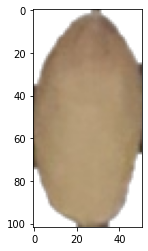

In [ ]:
path = r"/content/drive/My Drive/Colab Notebooks/GoMicro/Wheat/wheat_weeviled"

folder = "rotate_90"
dirs = os.listdir(path)

dest = os.path.join(r"/content/drive/My Drive/Colab Notebooks/GoMicro/Wheat/wheat_weeviled", folder)
if not os.path.exists(dest):
    os.makedirs(dest)

for i in range(len(dirs)):
  fullpath = os.path.join(path, dirs[i])
  if os.path.isfile(fullpath):
    im = Image.open(fullpath)
    im_rotate = im.rotate(90, expand=True)
    save_path = os.path.join(path, 'rotate'.format(i))
    im_rotate.save(save_path)
    im = Image.open(save_path)
    im_rotate.getbbox()
    im2 = im_rotate.crop(im.getbbox())
    im2.save(save_path)